<a href="https://colab.research.google.com/github/christakahashi/ECE447/blob/master/lectures/disturbances_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ECE 447: Disturbances and Noise
===

Updated by 
 Dr. Chris Takahashi

Authored by Prof. Eric Klavins &copy; 2019, University of Washington

# Code

In [0]:
import numpy as np
import scipy.integrate as spi
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from sympy import *


%matplotlib inline
#comment out for light mode
plt.style.use('dark_background')

try: 
  import google.colab #test for colab
  import IPython
  def setup_typeset():
    """MathJax initialization for the current cell.
    
    This installs and configures MathJax for the current output.
    """
    IPython.display.display(IPython.display.HTML('''
        <script src="https://www.gstatic.com/external_hosted/mathjax/latest/MathJax.js?config=TeX-AMS_HTML-full,Safe&delayStartupUntil=configured"></script>
        <script>
          (() => {
            const mathjax = window.MathJax;
            mathjax.Hub.Config({
            'tex2jax': {
              'inlineMath': [['$', '$'], ['\\(', '\\)']],
              'displayMath': [['$$', '$$'], ['\\[', '\\]']],
              'processEscapes': true,
              'processEnvironments': true,
              'skipTags': ['script', 'noscript', 'style', 'textarea', 'code'],
              'displayAlign': 'center',
            },
            'HTML-CSS': {
              'styles': {'.MathJax_Display': {'margin': 0}},
              'linebreaks': {'automatic': true},
              // Disable to prevent OTF font loading, which aren't part of our
              // distribution.
              'imageFont': null,
            },
            'messageStyle': 'none'
          });
          mathjax.Hub.Configured();
        })();
        </script>
        '''))
  def custom_latex_printer(exp,**options):
      setup_typeset()
      return printing.latex(exp,**options)
  init_printing(use_latex="mathjax",latex_printer=custom_latex_printer)
except:
  init_printing(use_latex='mathjax')

# Disturbances and Noise

<img width=57.5% src="https://github.com/christakahashi/ECE447/blob/master/images/blocks-with-dist-and-noise.png?raw=1">

Disturbances are modeled as being added to the input of the system. Noise is modeled as being added to the output.

# Example Disturbance Analysis

Suppose we have the following system modeling a rocket's velocity control:

<img width=60% src="https://github.com/christakahashi/ECE447/blob/master/images/rocket-disturb.png?raw=1">

And we would like to know what happens if the rocket's efficiency drops by one unit after the rocket has arrived target output. In particular, we want to know

- What is the effect on the steady state?
- What is the transient effect of a sudden change in efficiency?

Modeling the input $R(s)$ as a step input $1/s$, we can figure out the output $Y(s)$ in terms of $D(s)$. 

\begin{align}
Y(s) & = \frac{1}{s}\left(D(s) + \left(K_p + \frac{K_I}{s}\right)E \right) \\
     & = \frac{1}{s}\left(D(s) + \left(K_p + \frac{K_I}{s}\right)\left(R(s)-Y(s)\right) \right) \\
     & = \frac{1}{s}\left(D(s) + \left(K_p + \frac{K_I}{s}\right)\left(\frac{1}{s}-Y(s)\right) \right)
\end{align}

Solving for $Y(s)$ gives

$$
Y(s) = \frac{s D(s) + K_p + K_I/s}{s^2 + K_ps + K_I}
$$

**Effect on Steady State:**

Using the final value theorem:

$$
y(\infty) = \lim_{s \rightarrow 0} sY(s) = \frac{K_I}{K_I} = 1 .
$$

That's the magic of integral control!

**Effect on the Transient:**

To answer this question, we need to the solution in time. To obtain this, let's find the transfer function $Y(s)/R(s)$. We get:

$$
\frac{Y(s)}{R(s)} = \frac{K_ps+K_I}{s^2+K_ps+K_I}
$$

Using physical variable form, we get 

$$
\dot x = \begin{pmatrix}
-K_p & K_I \\
-1 & 0
\end{pmatrix} x + \begin{pmatrix}
K_p \\
1
\end{pmatrix} u
$$

$$
y = ( 1 \;\; 0 ) \; x
$$

To add the disturbance in, we add another input directly to x

$$
\dot x = \begin{pmatrix}
-K_p & K_I \\
-1 & 0
\end{pmatrix} x + \begin{pmatrix}
K_p & 1 \\
1 & 0
\end{pmatrix} \begin{pmatrix}
u \\
d
\end{pmatrix}
$$

To design a controller for this, we need to choose the eigenvalues by tuning $K_p$ and $K_I$. 

In [2]:
var("s Ki Kp t tau")
A = Matrix([
  [-Kp, Ki],
  [-1,0],    
])
B = Matrix([
    [Kp,1],
    [1,0]])
C = Matrix([[1,0]])

A.eigenvals()

⎧          _____________               _____________   ⎫
⎪         ╱           2               ╱           2    ⎪
⎨  Kp   ╲╱  -4⋅Ki + Kp         Kp   ╲╱  -4⋅Ki + Kp     ⎬
⎪- ── - ────────────────: 1, - ── + ────────────────: 1⎪
⎩  2           2               2           2           ⎭

In [0]:
#NOTE AFTER FIXING AN ERROR THIS NO LONGER RUNS AS THE ANALYTICAL SOLUTION IS 
# TOO COMPLEX.  THIS NEEDS FIXING OR NUMERICAL APPROXIMATION.
u = 1
d = -1
input = Matrix([[u],[d]])
x0 = Matrix([[1],[1]]) # Choose x so that system is at 
                       # steady state to start
 
tvals = np.linspace(0,15,75)

gains = [(Kp,1),(Ki,1)] 
A1 = A.subs(gains)
y = C*(exp(A1*t)*x0 + integrate(exp(A1*(t-tau))*B*input,(tau,0,t)))
f = lambdify(t,y[0],'numpy')
plt.plot(tvals,f(tvals),label="Kp=1,Ki=1")

gains = [(Kp,3),(Ki,3)] 
A2 = A.subs(gains)
y = C*(exp(A2*t)*x0 + integrate(exp(A2*(t-tau))*B*input,(tau,0,t)))
f = lambdify(t,y[0],'numpy')
plt.plot(tvals,f(tvals),label="Kp=2,Ki=1")

plt.xlabel("$t$")
plt.ylabel("$y(t)$")
plt.title("Distrurbance response from steady state");
plt.legend()

To do a more thorough analysis, you would want to tune the gains so that the maximum diversion from steady state did not exceed a given constraint. You would find the points on the output where the derivative was zero, for example.

# Noise Example

Now uppose we have the following system modeling the effect of noise on a rocket's velocity sensor:

<img width=60% src="https://github.com/christakahashi/ECE447/blob/master/images/rocket-noise.png?raw=1">

In this case we have, assuming a step input $R(s) = 1/s$

\begin{align}
Y(s) & = \frac{1}{s} \left(K_p + \frac{K_I}{s} \right) E \\
     & = \frac{1}{s} \left(K_p + \frac{K_I}{s} \right) \left(\frac{1}{s} - Y - N \right) \\
     & = \frac{(K_p+\frac{K_I}{s})(\frac{1}{s} - N)}{s+K_p+\frac{K_I}{s}}
\end{align}

**Biased Sensor:**

If we suppose that $N(s) = n/s$, we can use the final value theorem to find the final value of $y$:

$$
y(\infty) = \lim_{s \rightarrow 0} \frac{(K_p+\frac{K_I}{s})(\frac{1}{s} - \frac{n}{s})}{s+K_p+\frac{K_I}{s}} = 1-n
$$

That is, the magnitude of the effect is equal to the magnitude of the noise.

**Sensor Blips:**

If noise is just an impulse, so that $N(s) = n$. The, you can show that

$$
y(\infty) = \lim_{s \rightarrow 0} s \frac{(K_p+\frac{K_I}{s})(\frac{1}{s} - n)}{s+K_p+\frac{K_I}{s}} = 1
$$

which means that an impulse blip from the sensor is recovered from, most likely after a transient.

To see the time response, we rewrite the system in state space:

$$
\dot x = \begin{pmatrix}
-K_p & K_I \\
-1 & 0
\end{pmatrix} x + \begin{pmatrix}
0 & 0 \\
1 & 1
\end{pmatrix} \begin{pmatrix}
u \\
n
\end{pmatrix}
$$

$$
y = (1 \;\; 0) \; x
$$


In [0]:
var("s Ki Kp t tau")
A = Matrix([
  [-Kp, Ki],
  [-1,0],    
])
B = Matrix([
    [0,0],
    [1,1]])
C = Matrix([[1,0]])

/usr/local/lib/python3.6/dist-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


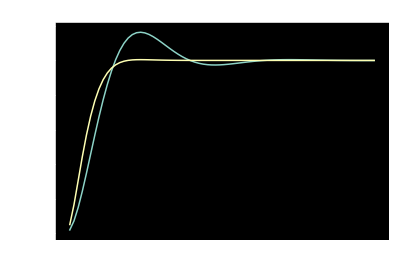

In [5]:
# Biased sensor

u = 1
n = 0.1
input = Matrix([[u],[n]])
x0 = Matrix([[1],[1]]) # Choose x so that system is at 
                       # steady state to start
 
tvals = np.linspace(0,15,75)

gains = [(Kp,1),(Ki,1)] 
A1 = A.subs(gains)
y = C*(exp(A1*t)*x0 + integrate(exp(A1*(t-tau))*B*input,(tau,0,t)))
f = lambdify(t,y[0],'numpy')
plt.plot(tvals,f(tvals),label="Kp=1,Ki=1")

gains = [(Kp,3),(Ki,3)] 
A2 = A.subs(gains)
y = C*(exp(A2*t)*x0 + integrate(exp(A2*(t-tau))*B*input,(tau,0,t)))
f = lambdify(t,y[0],'numpy')
plt.plot(tvals,f(tvals),label="Kp=2,Ki=1")

plt.xlabel("$t$")
plt.ylabel("$y(t)$")
plt.title("Noise response from steady state");

# Summary

- Noise and disturbances can be modeled as inputs to different parts of the system
- Disturbances can usually be rejected by integral control
- Noise is hard to deal with on sensors is hard to deal with